# EDA of Datasets

**Purpose:** Understand the dataset and define research questions.

**Possible research questions:**

- Can we train a model to predict aspects? And can those predicted aspects enable us to flag the papers as reject or accept?


## ICLR

### Investigation of Review Aspects

In [1]:
import pandas as pd
ASPECT_PTH = "dataset/aspect_data/review_with_aspect.jsonl"
aspects_df = pd.read_json(ASPECT_PTH, lines=True)

In [2]:
aspects_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25986 entries, 0 to 25985
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      25986 non-null  object
 1   text    25986 non-null  object
 2   labels  25986 non-null  object
dtypes: object(3)
memory usage: 609.2+ KB


8792 reviews has been assigned an aspect. 5154 of them from ICLR while 3588 from NIPS.

In [3]:
aspects_df["id"].nunique()

8742

In [4]:
aspects_df[aspects_df["id"].str.startswith("ICLR")]["id"].nunique()

5154

In [5]:
aspects_df[aspects_df["id"].str.startswith("NIPS")]["id"].nunique()

3588

In [6]:
aspects_df.head()

,id,text,labels
0,ICLR_2020_1123,This work studies the predictive uncertainty i...,"[[0, 1029, summary], [1030, 1201, motivation_p..."
1,ICLR_2018_813,Summary : This paper proposes a new approach t...,"[[10, 1038, summary], [1054, 1082, motivation_..."
2,NIPS_2019_796,The paper proposes a graph neural network base...,"[[0, 469, summary], [470, 532, clarity_positiv..."
3,ICLR_2018_726,Summary : This paper proposes an encoder-decod...,"[[10, 599, summary], [870, 1076, substance_neg..."
4,NIPS_2016_477,The authors present sharp criteria for l_1-spa...,"[[0, 1223, summary], [1314, 1354, soundness_po..."


In [7]:
aspects_df["labels"][0]

[[0, 1029, 'summary'],
 [1030, 1201, 'motivation_positive'],
 [1204, 1292, 'clarity_positive'],
 [1293, 1409, 'soundness_negative'],
 [1555, 1656, 'substance_negative'],
 [1973, 1998, 'meaningful_comparison_negative'],
 [3389, 3508, 'soundness_negative']]

---

We can see that most frequent aspect assigned is `summary`. It can be explained as the most of the reviewers begin by writing a summary about paper before writing their thoughts.

We can see that aspects also has their polarity as `negative` or `positive`. Non occurence of an aspect may be thought as neutrality.



In [8]:
labels = [i[2] for d in aspects_df["labels"] for i in d]

from collections import Counter
label_counts = Counter(labels)
label_counts

Counter({'summary': 23946,
         'clarity_negative': 15697,
         'soundness_negative': 15662,
         'clarity_positive': 13095,
         'soundness_positive': 12780,
         'substance_negative': 11717,
         'originality_positive': 11606,
         'motivation_positive': 11121,
         'meaningful_comparison_negative': 9242,
         'originality_negative': 8745,
         'substance_positive': 4669,
         'replicability_negative': 4548,
         'motivation_negative': 3499,
         'meaningful_comparison_positive': 1488,
         'replicability_positive': 271})

### Investigation of Papers and Reviews

---

There is two datasets collected from ICLR (2017 - 2020) and NIPS (2016 - 2019). One problem that the data collector states is that there is no data of rejected papers for NIPS papers.

In [20]:
!printf "ICLR Papers:\n" && ls dataset/ |grep "ICLR*" && printf "\nNIPS Papers:\n" && ls dataset/ |grep "NIPS*"

ICLR Papers:
ICLR_2017
ICLR_2018
ICLR_2019
ICLR_2020

NIPS Papers:
NIPS_2016
NIPS_2017
NIPS_2018
NIPS_2019


---

As can be seen below, sample count is larger in later years for both of the conferences.

Also we see that ICLR conference sample count is close to NIPS conference sample count. In cases of rejection prediction, this dataset may cause overfitting.

In [23]:
!for year in 2017 2018 2019 2020; do printf "ICLR $year Paper Count:" && ls -altr dataset/ICLR_${year}/ICLR_${year}_paper/ | wc -l; done

ICLR 2017 Paper Count:     492
ICLR 2018 Paper Count:     914
ICLR 2019 Paper Count:    1582
ICLR 2020 Paper Count:    2216


In [ ]:
!for year in 2016 2017 2018 2019; do printf "NIPS $year Paper Count:" && ls -altr dataset/NIPS_${year}/NIPS_${year}_paper/ | wc -l; done

NIPS 2016 Paper Count:     572
NIPS 2017 Paper Count:     682
NIPS 2018 Paper Count:    1012
NIPS 2019 Paper Count:    1431


---

We can see below that there is a small mismatch on number of papers and number of reviews. It seems there are papers without review informations. Those papers should be detected and may be eliminated from the dataset depending on the research questions.

In [25]:
!for year in 2017 2018 2019 2020; do printf "ICLR $year Review Count:" && ls -altr dataset/ICLR_${year}/ICLR_${year}_review/ | wc -l; done

ICLR 2017 Review Count:     493
ICLR 2018 Review Count:     913
ICLR 2019 Review Count:    1568
ICLR 2020 Review Count:    2216


In [26]:
!for year in 2016 2017 2018 2019; do printf "NIPS $year Review Count:" && ls -altr dataset/NIPS_${year}/NIPS_${year}_review/ | wc -l; done

NIPS 2016 Review Count:     561
NIPS 2017 Review Count:     670
NIPS 2018 Review Count:     991
NIPS 2019 Review Count:    1392


---

In [ ]:

base_folder = "dataset"

iclr_paper_rows = []
iclr_review_rows = []
years = range(2017, 2021)  # 2017 to 2020 inclusive

for year in years:
    iclr_paper_folder = os.path.join(base_folder, f"ICLR_{year}", f"ICLR_{year}_paper")
    if not os.path.exists(iclr_paper_folder):
        print(f"Warning: {iclr_paper_folder} not found, skipping.")
        continue

    for filename in os.listdir(iclr_paper_folder):
        if filename.endswith('.json'):
            file_path = os.path.join(iclr_paper_folder, filename)
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
                paper_id = data.get('id')
                decision = data.get('decision')
                hasReview = data.get('hasReview')
                iclr_paper_rows.append({
                    'paper_id': paper_id,
                    'decision': decision,
                    'hasReview': hasReview,
                    'year': year
                })
iclr_paper_df = pd.DataFrame(iclr_paper_rows)


for year in years:
    iclr_review_path = os.path.join(base_folder, f"ICLR_{year}", f"ICLR_{year}_review")
    
    if not os.path.exists(iclr_review_path):
        print(f"Warning: {iclr_review_path} not found, skipping.")
        continue

    for filename in os.listdir(iclr_review_path):
        if filename.endswith('.json'):
            file_path = os.path.join(iclr_review_path, filename)
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
                paper_id = data.get('id')
                review_counter = 1  # Reset review counter for each paper
                for review_entry in data.get('reviews', []):
                    review_text = review_entry.get('review', '')
                    rating_text = review_entry.get('rating', '')
                    # Extract the integer part of the rating
                    rating_int = int(rating_text.split(':')[0].strip()) if rating_text else None

                    iclr_review_rows.append({
                        'review_id': f'{paper_id}_{review_counter}',
                        'paper_id': paper_id,
                        'review': review_text,
                        'rating': rating_int
                    })
                    review_counter += 1

iclr_reviews_df = pd.DataFrame(iclr_review_rows)


---
Information about the contents of `paper_df` and `reviews_df`.

In [ ]:
iclr_paper_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5192 entries, 0 to 5191
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   paper_id   5192 non-null   object
 1   decision   5192 non-null   object
 2   hasReview  5192 non-null   object
 3   year       5192 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 162.4+ KB


In [ ]:
iclr_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31462 entries, 0 to 31461
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review_id  31462 non-null  object
 1   paper_id   31462 non-null  object
 2   review     31462 non-null  object
 3   rating     31462 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 983.3+ KB


---

As can be seen below, all informations are filled on both of the dataframes.

In [ ]:
iclr_paper_df.isnull().sum()

paper_id     0
decision     0
hasReview    0
year         0
dtype: int64

In [ ]:
iclr_reviews_df.isnull().sum()

review_id    0
paper_id     0
review       0
rating       0
dtype: int64

---

Distribution of Paper Decisions can be seen below

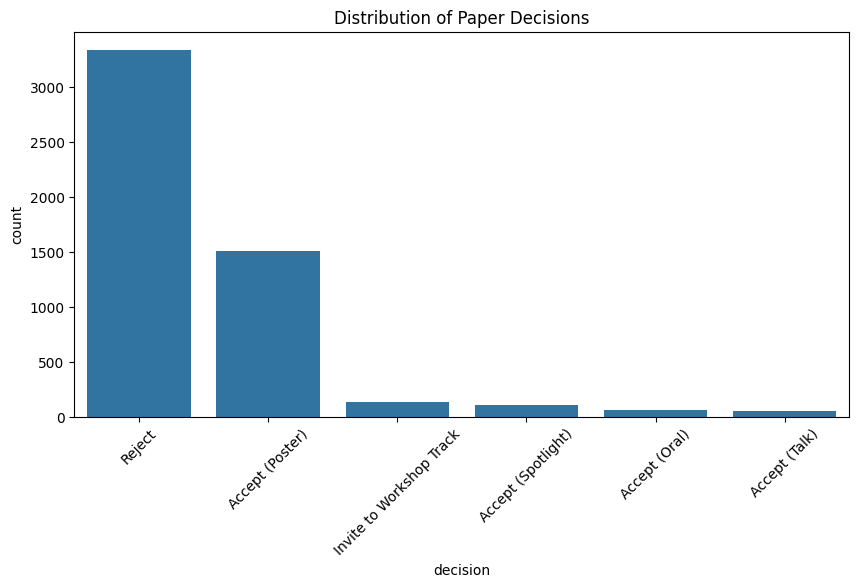

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.countplot(data=iclr_paper_df, x='decision', order=iclr_paper_df['decision'].value_counts().index)
plt.title('Distribution of Paper Decisions')
plt.xticks(rotation=45)
plt.show()


---

The graph below shows:

- How many tokens in each review (x axis)?

- How many reviews has that much of tokens (y axis)?

We can see that most of the reviews contains tokens less than 1000 with average of 389. This is a good score considering importance of lengths in transformer models. The result shows that we would not need massive truncation to fit most of the reviews into common transformer models such as BERT and RoBERTa.

We should note that the token count does not shows the word count. Since the text data has not been preprocessed yet, the resulting length probably higher than what we will use in training part.

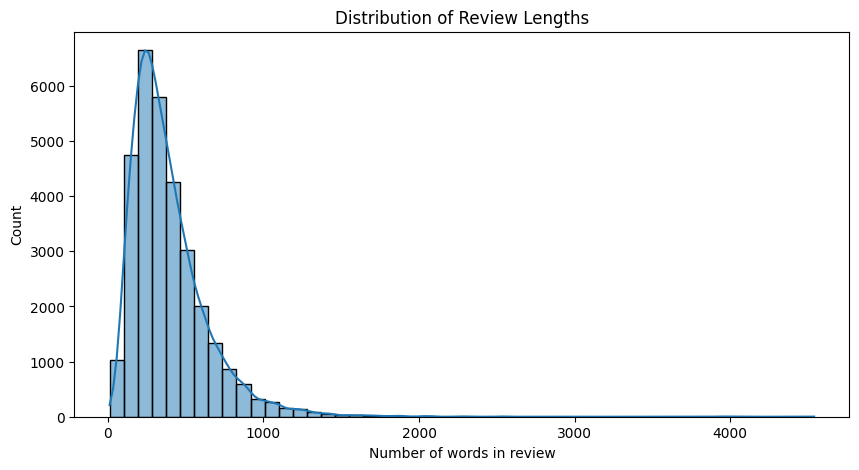

count    31462.000000
mean       389.990274
std        250.830021
min         11.000000
25%        222.000000
50%        332.000000
75%        493.000000
max       4540.000000
Name: review_length, dtype: float64


In [ ]:

iclr_reviews_df['review_length'] = iclr_reviews_df['review'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10,5))
sns.histplot(iclr_reviews_df['review_length'], bins=50, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Number of words in review')
plt.show()

print(iclr_reviews_df['review_length'].describe())


---

The below graph shows distribution of ratings of reviews. The graph shows that there is a cumulation of samples between 3 and 6.

Ratings may be grouped as following:

| Rate  | Group     |
|-------|------
| 1 - 4 | Strong Rejection  |
|   5   | Borderline Rejection |
|   6   | Borderline Acceptance |
| 7 - 10| Stong Acceptance |


Rates of 5 and 6 may indicate that the reviewer was in doubt on whether accept or reject the paper. Therefor, those reviews may contain conflicting content and decision. Training classification models on hard instances such that there would not be doubt or conflict may result in better performances. Therefor, the borderline rejection and borderline acceptance may be eliminated from the dataset. This will be decided later.

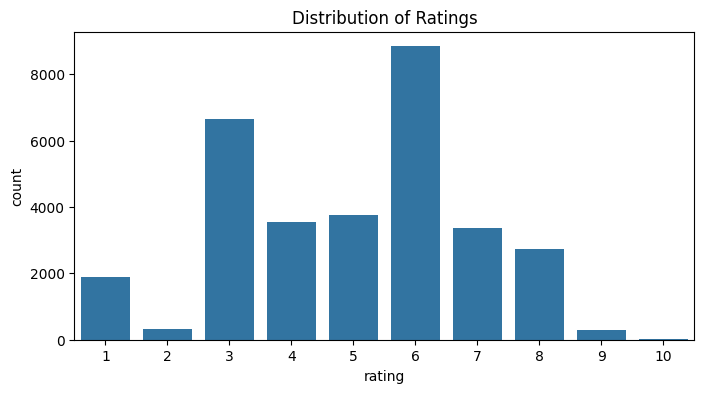

In [ ]:
plt.figure(figsize=(8,4))
sns.countplot(data=iclr_reviews_df, x='rating', order=sorted(iclr_reviews_df['rating'].dropna().unique())) 
plt.title('Distribution of Ratings')
plt.show()


---

The graph below which shows distribution of Rating Groups.

We can see that most of the rejections has been done (probably) without doubt. Confidence of reviewers in accepting the papers seems lower than confidence of accepting. Considering only the ICRS papers dataset, a so called trained model on reviews may tend to classify or generate reviews that are more negative. Considering that all of the NCIS dataset are of accepted papers, the distribution may be normalized with their combination.  

In [ ]:
iclr_reviews_df["ratingGroups"] = iclr_reviews_df["rating"].apply(
    lambda x:   'Strong Rejection' if 1 <= x <= 4 else
                'Borderline Rejection' if 5 == x else
                'Borderline Acceptance' if 6 == x else
                'Strong Acceptance' if 7 <= x <= 10 else
                'Unk'
)

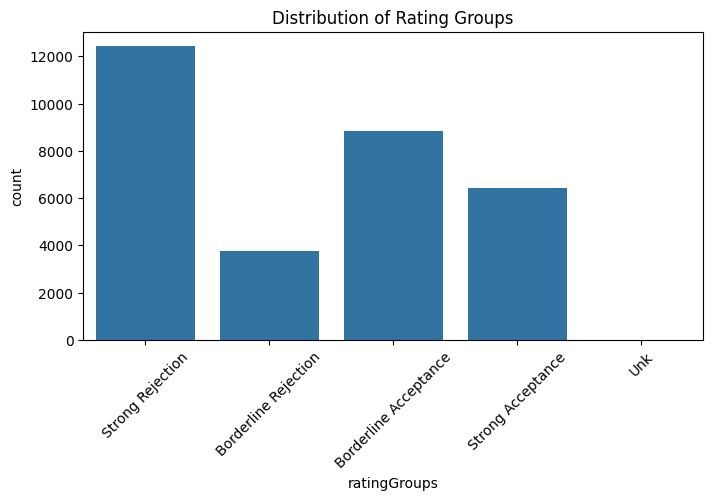

In [ ]:
plt.figure(figsize=(8,4))
sns.countplot(data=iclr_reviews_df, x='ratingGroups', order=["Strong Rejection", "Borderline Rejection", "Borderline Acceptance", "Strong Acceptance", "Unk"]) 
plt.title('Distribution of Rating Groups')
plt.xticks(rotation=45)
plt.show()


---

As can be seen from the graphs below, it seems that acceptance rate over years have significantly dropped. One of the reasons for that is that papers applied to conference has increased over years. 

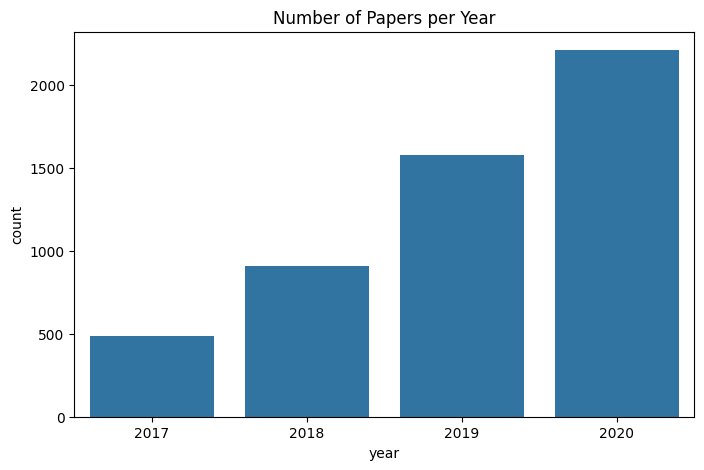

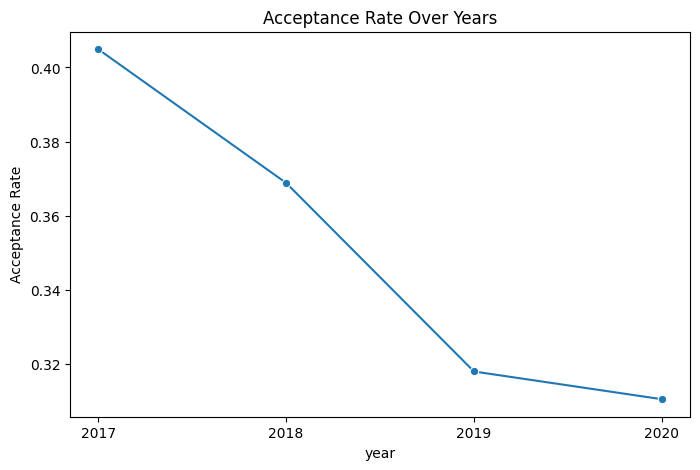

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(data=iclr_paper_df, x='year')
plt.title('Number of Papers per Year')
plt.show()

ac = iclr_paper_df.copy()
ac_rate['year'] = ac_rate['year'].astype(int)
ac['is_accepted'] = ac['decision'].apply(lambda x: 1 if 'Accept' in x else 0)
ac_rate = ac.groupby('year')['is_accepted'].mean().reset_index()

plt.figure(figsize=(8,5))
sns.lineplot(data=ac_rate, x='year', y='is_accepted', marker='o')
plt.xticks(ac_rate["year"].tolist()) 
plt.title('Acceptance Rate Over Years')
plt.ylabel('Acceptance Rate')
plt.show()



---

The graph below shows the change on number of applied papers and number of accepted papers per year. With this graph, we actually see that there was a simultanious increase on both of them. So the conference actuallt started to accept more papers each year but since there was too much applications, the acceptance rate seemed to be dropped.

Since we know the acceptance rate has decreased while the number of accepted papers has increased, review scores might not be strictly reflective of a paper's quality, but rather its relative quality compared to a larger pool of submissions. A paper with a strong score might be a relative standout in a crowded year, while a borderline score might reflect a paper with merit but less uniqueness in a highly competitive year.

We will investigate the effect of this issue on two possible research questions of this project:

**1. Review Score Prediction:**

Quality of paper, reviewer's bias or trends such that we observe here (increased submissions) would effect review scores. Therefore;

- A paper in a later year might receive a higher score even if its quality is the same, simply because reviewers are becoming more selective due to larger applicant pools.

- We may need to incorporate features about the year and increased submissions in the model. A time-series approach for score prediction may be used to address this shift over the years.

**2. Paper Decision Prediction (Accept vs Reject):**

- With more submissions, a paper’s chances of acceptance aren’t just based on its quality but on how it compares with others. A paper might be high quality, but in a year with a huge influx of submissions, it might be rejected due to lack of space or other non-quality factors.

- As the pool grows, there may be a subtle shift in how reviewers rate papers. Early years may see a higher acceptance rate, as fewer papers compete. In later years, even small flaws could lead to a rejection due to increased competition.

- Features like the number of papers per year may be incorporated into the paper decision model to consider increasing competition too (?).


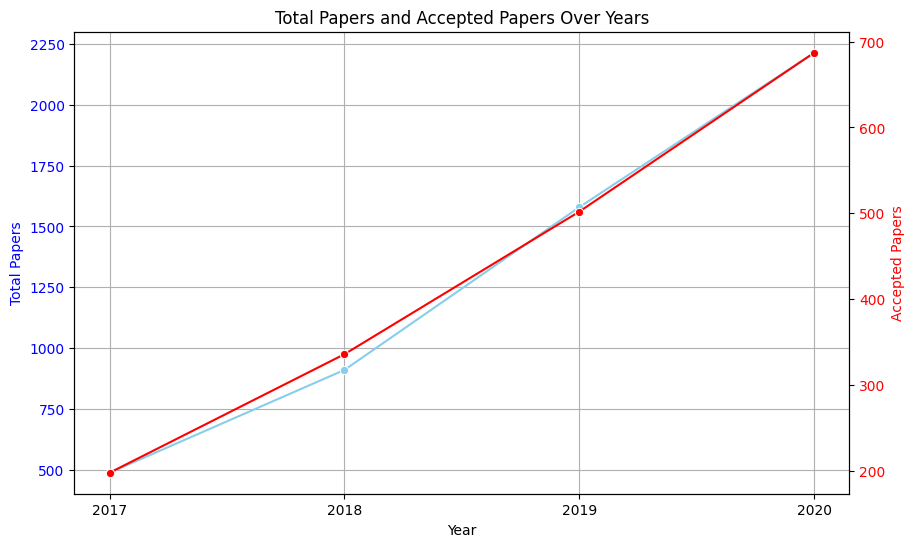

In [ ]:

accept_sum = ac.groupby('year').agg(
    total_papers=('paper_id', 'count'),
    accepted_papers=('is_accepted', 'sum')
).reset_index()

fig, ax1 = plt.subplots(figsize=(10,6))

sns.lineplot(x=accept_sum['year'], y=accept_sum['total_papers'], marker='o', color='skyblue', ax=ax1)
ax1.set_xlabel('Year')
ax1.set_ylabel('Total Papers', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
sns.lineplot(x=accept_sum['year'], y=accept_sum['accepted_papers'], marker='o', color='red', ax=ax2)
ax2.set_ylabel('Accepted Papers', color='red')
ax2.tick_params(axis='y', labelcolor='red')
plt.xticks(ac_rate["year"].tolist()) 

plt.title('Total Papers and Accepted Papers Over Years')
ax1.grid(True)

plt.show()


---

## NIPS

---



In [95]:

nips_paper_rows = []
nips_review_rows = []
years = range(2016, 2020)  # 201 to 2019 inclusive

for year in years:
    nips_paper_folder = os.path.join(base_folder, f"nips_{year}", f"nips_{year}_paper")
    if not os.path.exists(nips_paper_folder):
        print(f"Warning: {nips_paper_folder} not found, skipping.")
        continue

    for filename in os.listdir(nips_paper_folder):
        if filename.endswith('.json'):
            file_path = os.path.join(nips_paper_folder, filename)
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
                paper_id = data.get('id')
                decision = data.get('decision')
                hasReview = data.get('hasReview')
                nips_paper_rows.append({
                    'paper_id': paper_id,
                    'decision': decision,
                    'hasReview': hasReview,
                    'year': year
                })
nips_paper_df = pd.DataFrame(nips_paper_rows)


for year in years:
    nips_review_path = os.path.join(base_folder, f"nips_{year}", f"nips_{year}_review")
    
    if not os.path.exists(nips_review_path):
        print(f"Warning: {nips_review_path} not found, skipping.")
        continue

    for filename in os.listdir(nips_review_path):
        if filename.endswith('.json'):
            file_path = os.path.join(nips_review_path, filename)
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
                paper_id = data.get('id')
                review_counter = 1  # Reset review counter for each paper
                for review_entry in data.get('reviews', []):
                    review_text = review_entry.get('review', '')
                    rating_text = review_entry.get('rating', '')
                    # Extract the integer part of the rating
                    rating_int = int(rating_text.split(':')[0].strip()) if rating_text else None

                    nips_review_rows.append({
                        'review_id': f'{paper_id}_{review_counter}',
                        'paper_id': paper_id,
                        'review': review_text,
                        'rating': rating_int
                    })
                    review_counter += 1

nips_reviews_df = pd.DataFrame(nips_review_rows)


---

There is an inconsistency between NIPS and ICLR datasets: NIPS reviews does not have ratings.

This is a problem on RSP point of wiew. This means we cannot use NIPS dataset to train model on RSP goal. But if we can somehow train a model to predict the review scores, by applying it to the NIPS dataset we can generate this feature and use both of the datasets (NIPS with generated review scores) to train a PDP model.

Also, there might be a need of additional dataset to train an RSP model.

In [96]:
nips_paper_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3685 entries, 0 to 3684
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   paper_id   3685 non-null   object
 1   decision   3685 non-null   object
 2   hasReview  3685 non-null   object
 3   year       3685 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 115.3+ KB


In [97]:
nips_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12391 entries, 0 to 12390
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review_id  12391 non-null  object
 1   paper_id   12391 non-null  object
 2   review     12391 non-null  object
 3   rating     0 non-null      object
dtypes: object(4)
memory usage: 387.3+ KB


---


In [98]:
nips_paper_df.isnull().sum()

paper_id     0
decision     0
hasReview    0
year         0
dtype: int64

In [99]:
nips_reviews_df.isnull().sum()

review_id        0
paper_id         0
review           0
rating       12391
dtype: int64

---

We already knew that all of the NIPS papers are accepted papers. Bu we can see that there is no Accept groups too (we have seen that with ICLR papers).

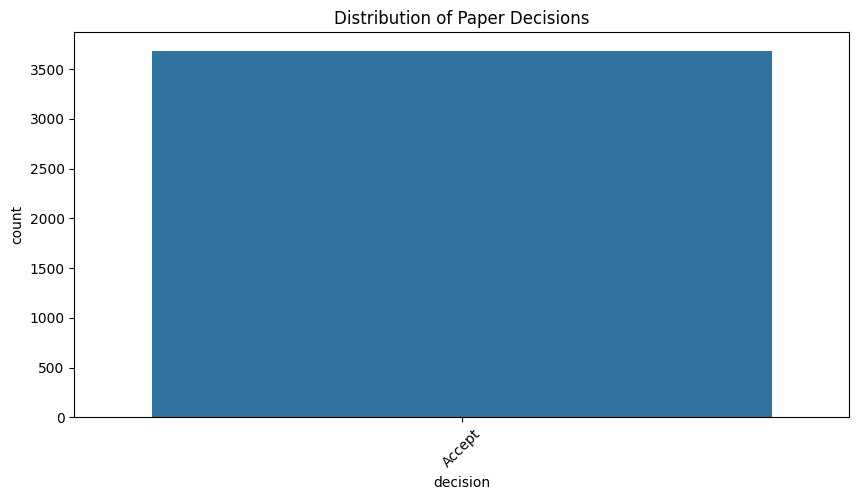

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.countplot(data=nips_paper_df, x='decision', order=nips_paper_df['decision'].value_counts().index)
plt.title('Distribution of Paper Decisions')
plt.xticks(rotation=45)
plt.show()


---
The graph below shows:

- How many tokens in each review (x axis)?

- How many reviews has that much of tokens (y axis)?

We can see that most of the reviews contains tokens less than 1000 with average of 354. This is a good score considering importance of lengths in transformer models. The result shows that we would not need massive truncation to fit most of the reviews into common transformer models such as BERT and RoBERTa.

We should note that the token count does not shows the word count. Since the text data has not been preprocessed yet, the resulting length probably higher than what we will use in training part.

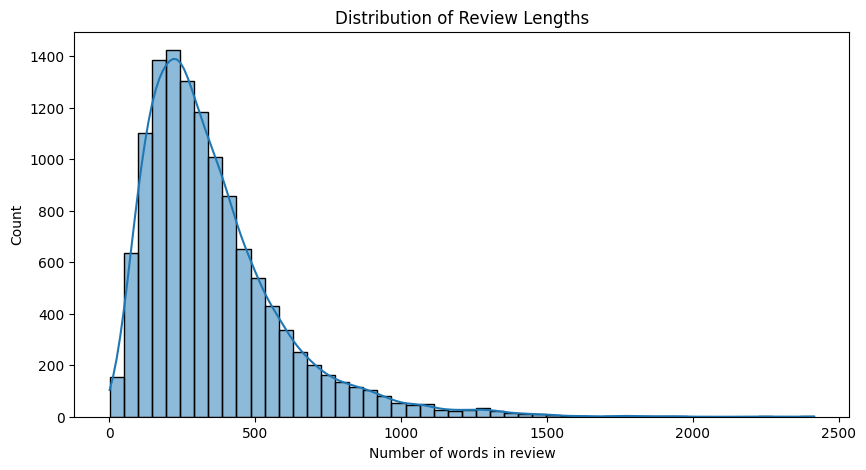

count    12391.000000
mean       354.765152
std        240.780516
min          1.000000
25%        189.000000
50%        298.000000
75%        454.000000
max       2416.000000
Name: review_length, dtype: float64


In [104]:

nips_reviews_df['review_length'] = nips_reviews_df['review'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10,5))
sns.histplot(nips_reviews_df['review_length'], bins=50, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Number of words in review')
plt.show()

print(nips_reviews_df['review_length'].describe())


---

We can see that there is also an increase on accepted number of papers just like ICLR. Unfortunatelly it is not possible to understand acceptance rates since we do not know total number of papers applied to NIPS conference.

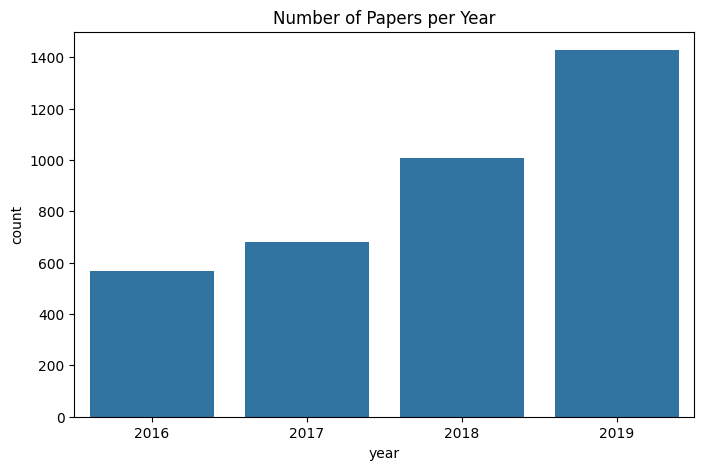

In [106]:
plt.figure(figsize=(8,5))
sns.countplot(data=nips_paper_df, x='year')
plt.title('Number of Papers per Year')
plt.show()


---



In [107]:
nips_paper_df

,paper_id,decision,hasReview,year
0,NIPS_2016_509,Accept,true,2016
1,NIPS_2016_102,Accept,true,2016
2,NIPS_2016_348,Accept,true,2016
3,NIPS_2016_135,Accept,true,2016
4,NIPS_2016_209,Accept,true,2016
...,...,...,...,...
3680,NIPS_2019_844,Accept,true,2019
3681,NIPS_2019_1300,Accept,true,2019
3682,NIPS_2019_680,Accept,true,2019
3683,NIPS_2019_1337,Accept,true,2019


In [108]:
nips_reviews_df

,review_id,paper_id,review,rating,review_length
0,NIPS_2016_358_1,NIPS_2016_358,"This paper proposes a new, general pairwise ra...",None,85
1,NIPS_2016_358_2,NIPS_2016_358,"This paper proposes a new choice model, which ...",None,260
2,NIPS_2016_358_3,NIPS_2016_358,The paper introduces Pairwise Choice Markov Ch...,None,220
3,NIPS_2016_358_4,NIPS_2016_358,This paper introduces a new choice model which...,None,163
4,NIPS_2016_358_5,NIPS_2016_358,This paper considers the problem of developing...,None,412
...,...,...,...,...,...
12386,NIPS_2019_955_2,NIPS_2019_955,1. Originality. The authors propose a novel me...,None,128
12387,NIPS_2019_955_3,NIPS_2019_955,I would consider Theorem 1 and analysis behind...,None,203
12388,NIPS_2019_1004_1,NIPS_2019_1004,Originality - it's the first time that semi-su...,None,67
12389,NIPS_2019_1004_2,NIPS_2019_1004,Originality: Previous theoretical work on the ...,None,194


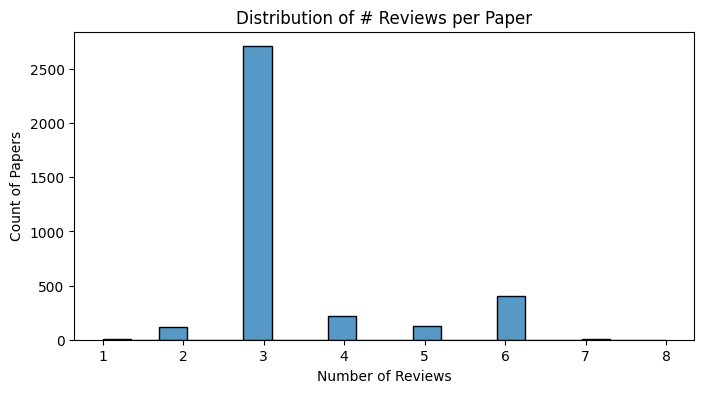

In [109]:
merged_nips = nips_reviews_df.merge(
    nips_paper_df[['paper_id','year']], on='paper_id', how='left'
)
reviews_per_paper = (
    merged_nips.groupby('paper_id')
          .size()
          .reset_index(name='n_reviews')
)
plt.figure(figsize=(8,4))
sns.histplot(reviews_per_paper['n_reviews'], bins=20, kde=False)
plt.title('Distribution of # Reviews per Paper')
plt.xlabel('Number of Reviews')
plt.ylabel('Count of Papers')
plt.show()